In [3]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

from joblib import load
from utils.visualize import showMe
from IPython.display import clear_output

import brainflow

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds, BrainFlowError

from tqdm.notebook import tqdm


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


%matplotlib inline

from utils.svm import preProcess_1 as preProcess_svm
from utils.deep import preProcess_1 as preProcess_deep
from utils.visualize import showMe
%load_ext autoreload
%autoreload 2


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [6]:
####      INIT BOARD        #######
BoardShim.enable_dev_board_logger()
params = BrainFlowInputParams()
board = BoardShim(BoardIds.MINDROVE_WIFI_BOARD, params)


try:
    board.stop_stream()
    board.release_session()
except:
    ...
    
board.prepare_session()
sample_rate = board.get_sampling_rate(16)
n_channels  = 6

sample_rate = board.get_sampling_rate(16)

print("Device ready (sampling rate: {}hz)".format(sample_rate))

Device ready (sampling rate: 500hz)


(6, 100)


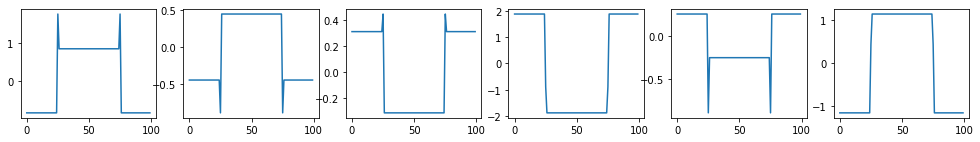

Prediction: Rest


KeyboardInterrupt: 

In [7]:
def SVM_Predict(classes = ['Eyebrow','Chew']):
    print("Loading model...")

    svm = load('saved_models/svm_acc_95.joblib')
    classes = ['Rest'] + classes
   
    length_of_signal = 2 #seconds
    board.start_stream(3) # plus 2 sec to be sure
    print("Starting...")
    while True:

        board.get_board_data() # clear buffer
        time.sleep(length_of_signal*1.1) # record longer to make sure there is enough data
        data = board.get_board_data()
        data = data[:6,:sample_rate*length_of_signal] #keep the data of the eeg channels only, and remove data over the trial length
    
        preProcessed = preProcess_svm(data, 100)
        
        prediction = svm.predict(preProcessed.reshape(-1,6*100))[0]
        clear_output()
        print(preProcessed.shape)
        showMe(preProcessed)
        print(f'Prediction: {classes[int(prediction)]}')
    
        
SVM_Predict()


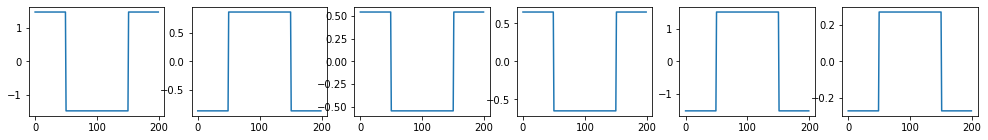

Prediction: Eyebrow


KeyboardInterrupt: 

In [7]:
def Deep_Predict(classes = ['Eyebrow','Chew']):
    print("Loading model...")
    deep = load_model('saved_models/dense_val_acc_94')
    classes = ['Rest'] + classes
   
    length_of_signal = 2 #seconds
    board.start_stream(3) # plus 2 sec to be sure
    print("Starting...")
    while True:
        board.get_board_data() # clear buffer
        time.sleep(length_of_signal*1.1) # record longer to make sure there is enough data
        data = board.get_board_data()
        data = data[:6,:sample_rate*length_of_signal] #keep the data of the eeg channels only, and remove data over the trial length
    
        preProcessed = preProcess_deep(data, 200)
        
        prediction = deep.predict(np.array([preProcessed]))[0]   # Fake 1 batch 

        clear_output()
        showMe(preProcessed)

        print(f'Prediction: {classes[int(max(prediction))]}')
    
        
Deep_Predict()